## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
import torchvision
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

import wandb
from datetime import datetime
torch.cuda.is_available()

False

In [8]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs, ys = xs.to(device), ys.to(device)
        # Zero out the gradients.
        opt.zero_grad()
        # Forward through the model.
        logits = model(xs) 
        # Compute the cross-entropy loss.
        loss = F.cross_entropy(logits, ys)
        # Backward through the model.
        loss.backward()
        # Update the model parameters.
        opt.step()
        # Save the loss value.
        losses.append(loss.item())
    # Return the average loss for this epoch.
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    ground_truths = []
    with torch.no_grad():
        for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
            xs = xs.to(device)
            logits = model(xs)
            preds = torch.argmax(logits, 1)
            
            # Save the ground truth and predictions.
            ground_truths.append(ys)
            predictions.append(preds.detach().cpu().numpy())
            
    predictions = np.hstack(predictions)
    ground_truths = np.hstack(ground_truths)
    
    # Return accuracy score and classification report.
    return accuracy_score(ground_truths, predictions), classification_report(ground_truths, predictions, zero_division=0, digits=3, output_dict=True)


def train_model(model, dl_train, dl_val, opt, epochs, model_name, dataset_type, lr, batch_size, device='cpu'):
    wandb.init(
        # set the wandb project where this run will be logged
        project="DLA Assigment 1",
        name=model_name + "-" + datetime.now().strftime("%Y%m%d-%H%M%S"),
        # track hyperparameters and run metadata
        config={
            "architecture": model_name,
            "dataset": dataset_type,
            "epochs": epochs,
            "learning_rate": lr,
            "batch_size": batch_size,
            "device": device,
            "optimizer": "Adam"
        }
    )
    wandb.watch(model, nn.CrossEntropyLoss, log="all", log_freq=10)
    losses_and_accs = []
    classification_report = []
    for epoch in range(epochs):
        loss = train_epoch(model, dl_train, opt, epoch, device=device)
        (val_acc, class_rep) = evaluate_model(model, dl_val, device=device)
        losses_and_accs.append((loss, val_acc))
        classification_report.append(class_rep)
        
        print(f'Epoch {epoch}: Loss - {loss:.4f}, Validation Acc - {val_acc:.4f}')
        # wandb
        wandb.log({"epoch": epoch, "loss": loss, "acc": val_acc, "classification_report": class_rep})
                
    # [optional] finish the wandb run, necessary in notebooks
    wandb.unwatch(model)
    wandb.finish()    

    torch.save(model.state_dict(), f"model_states/model_{model_name}.pt")
    torch.save(model, f"model/model_{model_name}.pt")

    return losses_and_accs


# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(training_history):
    losses, accuracies = zip(*training_history)
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title('Average Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.title(f'Best Accuracy = {np.max(accuracies)} @ epoch {np.argmax(accuracies)}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.show()

In [9]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(28*28, 128),  # First narrow layer
            nn.Linear(128, 128),  # Second narrow layer
            nn.Linear(128, 64),  # Third narrow layer
            nn.Linear(64, 64), # Fourth narrow layer
            nn.Linear(64, 10)  # Output layer
        ])
    
    def forward(self, x):
        x = x.flatten(1)
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        return x

In [10]:
class NOTRESNET(nn.Module):
    def __init__(self, num_classes=10):
        super(NOTRESNET, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(64, 64, 2, stride=1)
        self.layer2 = self.make_layer(64, 128, 2, stride=2)
        self.layer3 = self.make_layer(128, 256, 2, stride=2)
        self.layer4 = self.make_layer(256, 512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(1, num_blocks):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [11]:
# Define the basic building blocks of ResNet: Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
# The ResNet model
class ResNet18(nn.Module):
    def __init__(self, num_blocks, num_classes):
        super(ResNet18, self).__init__()
        self.in_channels = 64    

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(self.in_channels)

        self.layer1 = self._make_layer(ResidualBlock, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 512, num_blocks[3], stride=2)

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)    # [stride, 1, 1, ...] (num_blocks times) ensures that the first block has stride=stride
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn(self.conv1(x)))       # [batch_size, 3, 32, 32] -> [batch_size, 64, 32, 32]
        out = self.layer1(out)                     # [batch_size, 64, 32, 32] -> [batch_size, 64, 32, 32] (stride=1)
        out = self.layer2(out)                     # [batch_size, 64, 32, 32] -> [batch_size, 128, 16, 16] (stride=2)
        out = self.layer3(out)                     # [batch_size, 128, 16, 16] -> [batch_size, 256, 8, 8] (stride=2)
        out = self.layer4(out)                     # [batch_size, 256, 8, 8] -> [batch_size, 512, 4, 4] (stride=2)
        out = F.avg_pool2d(out, 4)                 # [batch_size, 512, 4, 4] -> [batch_size, 512, 1, 1] (avg_pool2d)
        out = out.view(out.size(0), -1)            # [batch_size, 512, 1, 1] -> [batch_size, 512]
        out = self.fc(out)                         # [batch_size, 512] -> [batch_size, num_classes]
        return out


### Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the ResNet18 model and CNN model
resnet18 = ResNet18([2, 2, 2, 2], 10)
resnet18.load_state_dict(torch.load('model_states/model_ResNet18.pt', map_location=torch.device(device)))
resnet18.eval()

cnn = NOTRESNET()
cnn.load_state_dict(torch.load('model_states/model_CNN.pt', map_location=torch.device(device)))
cnn.eval()

NOTRESNET(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, ep

In [22]:
resnet18.to(device)
cnn.to(device)

# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Evaluate the ResNet18 model
acc, report = evaluate_model(resnet18, test_loader, device=device)
print(f"ResNet18 Accuracy: {acc:.4f}")

# Evaluate the CNN model
acc, report = evaluate_model(cnn, test_loader, device=device)
print(f"CNN Accuracy: {acc:.4f}")

Files already downloaded and verified
Files already downloaded and verified


ResNet18 Accuracy: 0.8536


CNN Accuracy: 0.8429


In [32]:
# Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset = Subset(trainset, np.random.choice(len(trainset), 1000, replace=False))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.Adam(resnet18.parameters(), lr=0.001,)
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=0.001)

# Track gradient magnitudes
gradient_magnitudes_resnet = []
gradient_magnitudes_cnn = []

def little_train(model, optimizer, gradient_magnitudes):
    model.train()
    for inputs, labels in tqdm(trainloader, desc=f'Training epoch {epoch}', leave=True):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        total_gradient = 0.0
        for p in model.parameters():
            if p.grad is not None:
                total_gradient += p.grad.abs().sum().item()
        gradient_magnitudes.append(total_gradient)
        
        optimizer.step()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
cnn.to(device)

for epoch in range(1):  # Train for 5 epochs for demonstration
    little_train(resnet18, optimizer_resnet, gradient_magnitudes_resnet)
    little_train(cnn, optimizer_cnn, gradient_magnitudes_cnn)

Files already downloaded and verified


Training epoch 0: 100%|██████████| 8/8 [00:16<00:00,  2.05s/it]


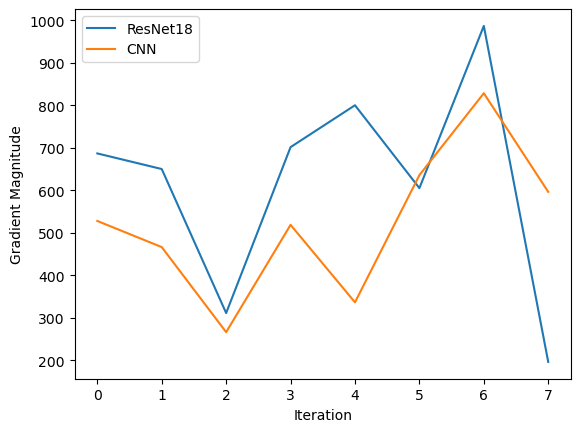

In [34]:
import matplotlib.pyplot as plt

plt.plot(gradient_magnitudes_resnet, label='ResNet18')
plt.plot(gradient_magnitudes_cnn, label='CNN')
plt.xlabel('Iteration')
plt.ylabel('Gradient Magnitude')
plt.legend()
plt.show()

### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

In [58]:
class ResNet18FCN(nn.Module):
    def __init__(self, model, num_classes):
        super(ResNet18FCN, self).__init__()
        self.model = model

        # Remove the fully connected layer
        self.model.fc = nn.Identity()

        # Fully convolutional classification layer
        self.classifier = nn.Conv2d(512, num_classes, kernel_size=1)

        # Upsample the output to the input size
        self.resizer = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, padding=16, stride=32)
        self.resizer.weight.data.copy_(self.bilinear(num_classes, num_classes, 64))


    def bilinear(self, in_channels, out_channels, kernel_size):
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
            
        og = (torch.arange(kernel_size).reshape(-1, 1), torch.arange(kernel_size).reshape(1, -1))
        
        filt = (1 - torch.abs(og[0] - center) / factor) * (1 - torch.abs(og[1] - center) / factor)
        
        weight = torch.zeros((in_channels, out_channels, kernel_size, kernel_size))
        
        weight[range(in_channels), range(out_channels), :, :] = filt
        return weight

    def forward(self, x):
        out = F.relu(self.model.bn(self.model.conv1(x))) # [batch_size, 3, 32, 32] -> [batch_size, 64, 32, 32]
        out = self.model.layer1(out)                     # [batch_size, 64, 32, 32] -> [batch_size, 64, 32, 32] (stride=1)
        out = self.model.layer2(out)                     # [batch_size, 64, 32, 32] -> [batch_size, 128, 16, 16] (stride=2)
        out = self.model.layer3(out)                     # [batch_size, 128, 16, 16] -> [batch_size, 256, 8, 8] (stride=2)
        out = self.model.layer4(out)                     # [batch_size, 256, 8, 8] -> [batch_size, 512, 4, 4] (stride=2)
        out = self.classifier(out)                       # [batch_size, 512, 4, 4] -> [batch_size, num_classes, 4, 4]
        out = self.resizer(out)                          # [batch_size, num_classes, 4, 4] -> [batch_size, num_classes, 32, 32]
        return out

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = ResNet18([2, 2, 2, 2], 10).to(device)
resnet18.load_state_dict(torch.load('model_states/model_ResNet18.pt', map_location=device))

# Create the fully convolutional model
resnet18_fcn = ResNet18FCN(resnet18, 10).to(device)
resnet18_fcn.eval()

ResNet18FCN(
  (model): ResNet18(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  

In [60]:
# CIFAR10
# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# get labels for CIFAR10
labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Get one image from the test set
image, label = testset[10]
original_image = image.clone()
image = image.unsqueeze(0).to(device)

Files already downloaded and verified


In [61]:
with torch.no_grad():
    outputs = resnet18_fcn(image)
    preds = torch.softmax(outputs, dim=1)
     
    print('Response map shape : ', preds.shape)
 
    # Find the class with the maximum score in the n x m output map
    pred, class_idx = torch.max(preds, dim=1)
    print(class_idx)

    row_max, row_idx = torch.max(pred, dim=1)
    col_max, col_idx = torch.max(row_max, dim=1)
    predicted_class = class_idx[0, row_idx[0, col_idx], col_idx]
     
    # Print top predicted class
    print('Predicted Class : ', labels[predicted_class], predicted_class)

Response map shape :  torch.Size([1, 10, 128, 128])
tensor([[[2, 2, 2,  ..., 8, 8, 8],
         [2, 2, 2,  ..., 8, 8, 8],
         [2, 2, 2,  ..., 8, 8, 8],
         ...,
         [0, 0, 0,  ..., 9, 9, 9],
         [0, 0, 0,  ..., 9, 9, 9],
         [0, 0, 0,  ..., 9, 9, 9]]])
Predicted Class :  dog tensor([5])


In [ ]:
import cv2 
# Find the n x m score map for the predicted class
score_map = preds[0, predicted_class, :, :].cpu().numpy()
score_map = score_map[0]

# Resize score map to the original image size
score_map = cv2.resize(score_map, (original_image.shape[1], original_image.shape[2]))
 
# Binarize score map
_, score_map_for_contours = cv2.threshold(score_map, 0.25, 1, type=cv2.THRESH_BINARY)
score_map_for_contours = score_map_for_contours.astype(np.uint8).copy()
 
# Find the countour of the binary blob
contours, _ = cv2.findContours(score_map_for_contours, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
 
# Find bounding box around the object. 
rect = cv2.boundingRect(contours[0])

# Apply score map as a mask to original image
score_map = score_map - np.min(score_map[:])
score_map = score_map / np.max(score_map[:])

score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2BGR)

org = original_image.cpu().numpy().transpose(1, 2, 0)
# Move the third channel to the first channel
masked_image = (org * score_map)

In [ ]:
import cv2 

def get_score_map(image, model):
    # Find the n x m score map for the predicted class
    score_map = preds[0, predicted_class, :, :].cpu().numpy()
    score_map = score_map[0]

    # Resize score map to the original image size
    score_map = cv2.resize(score_map, (original_image.shape[1], original_image.shape[2]))
    
    # Binarize score map
    _, score_map_for_contours = cv2.threshold(score_map, 0.25, 1, type=cv2.THRESH_BINARY)
    score_map_for_contours = score_map_for_contours.astype(np.uint8).copy()
    
    # Find the countour of the binary blob
    contours, _ = cv2.findContours(score_map_for_contours, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    
    # Find bounding box around the object. 
    rect = cv2.boundingRect(contours[0])

    # Apply score map as a mask to original image
    score_map = score_map - np.min(score_map[:])
    score_map = score_map / np.max(score_map[:])

    score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2BGR)

    return score_map

In [62]:
def plot_score_map(original_image, masked_image, score_map, rect):
    # Plot all the results
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(score_map)
    plt.title('Score Map')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(masked_image)
    plt.title('Masked Image')
    plt.axis('off')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


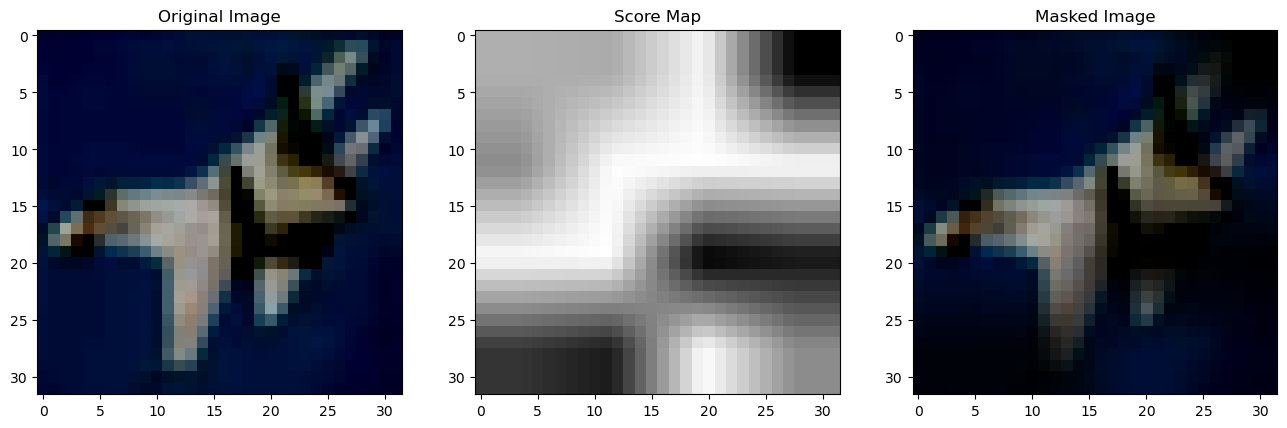

In [ ]:
# Plot all the results
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.imshow(org)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(score_map)
plt.title('Score Map')

plt.subplot(1, 3, 3)
plt.imshow(masked_image)
plt.title('Masked Image')
plt.show()

In [ ]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST train and test.
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# get one image from the test set
image, label = ds_test[0]
original_image = image.cpu()
image = image.unsqueeze(0).to(device)

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

**Note**: Feel free to implement [Grad-CAM](https://arxiv.org/abs/1610.02391) instead of CAM.

In [ ]:
# The ResNet model
class GradCamModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None

        self.layerhook.append(self.model.layer4.register_forward_hook(self.forward_hook()))

        for p in self.model.parameters():
            p.requires_grad = True
        
    def activations_hook(self, grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients
    
    def forward_hook(self):
        def hook(model, input, output):
            self.selected_out = output
            self.tensorhook.append(output.register_hook(self.activations_hook))
        return hook

    def forward(self, x):
        out = self.model(x)
        return out, self.selected_out        

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet18 = ResNet18([2, 2, 2, 2], 10)
resnet18.load_state_dict(torch.load('model_states/model_ResNet18.pt'))
resnet18.eval()

gradcam_model = GradCamModel(resnet18).to(device)

In [ ]:
batch_size = 10

# CIFAR10
# Load CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# get one image and label from the test set
image, label = testset[10]
image.unsqueeze_(0).to(device)

Files already downloaded and verified


In [ ]:
out, acts = gradcam_model(image)
acts = acts.detach().cpu()

In [ ]:
loss = nn.CrossEntropyLoss()(out, torch.tensor([0]).to(device))
loss.backward()

grads = gradcam_model.get_act_grads().detach().cpu()

pooled_grad = torch.mean(grads, dim=[0, 2, 3]).detach().cpu()

for i in range(acts.shape[1]):
    acts[:, i, :, :] *= pooled_grad[i]

In [ ]:
import cv2

heatmap = torch.mean(acts, dim=1).squeeze()
heatmap_max = heatmap.max(axis = 0)[0]
heatmap = heatmap / heatmap_max

# Resize heatmap to the original image size
heatmap = cv2.resize(heatmap.numpy(), (original_image.shape[2], original_image.shape[1]))

In [ ]:
import cv2 

def get_heatmap(model, image, label):
    out, acts = model(image)
    acts = acts.detach().cpu()

    loss = nn.CrossEntropyLoss()(out, torch.tensor([label]).to(device))
    loss.backward()

    grads = model.get_act_grads().detach().cpu()

    pooled_grad = torch.mean(grads, dim=[0, 2, 3]).detach().cpu()

    for i in range(acts.shape[1]):
        acts[:, i, :, :] *= pooled_grad[i]

    heatmap = torch.mean(acts, dim=1).squeeze()
    heatmap_max = heatmap.max(axis = 0)[0]
    heatmap = heatmap / heatmap_max

    # Resize heatmap to the original image size @TODO Change library to PIL?
    heatmap = cv2.resize(heatmap.numpy(), (original_image.shape[2], original_image.shape[1]))

    return heatmap

In [ ]:
def plot_heatmap(original_image, heatmap):
    # Plot the original image, heatmap and overlayed image
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image.permute(1, 2, 0))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap='inferno')
    plt.title('Heatmap')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(original_image.permute(1, 2, 0))
    plt.imshow(heatmap, cmap='inferno', alpha=0.4)
    plt.title('Overlayed Image')
    plt.axis('off')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


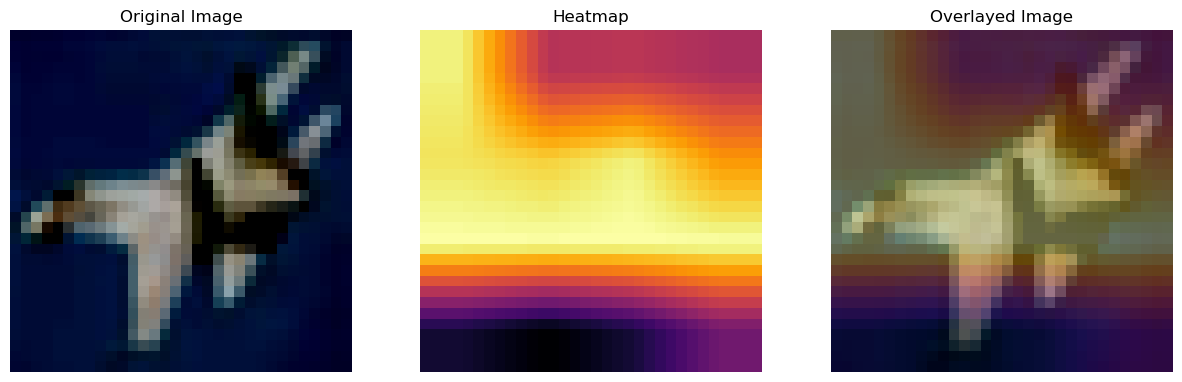

In [ ]:
# Plot the original image, heatmap and overlayed image
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(original_image.permute(1, 2, 0))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='inferno')
plt.title('Heatmap')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(original_image.permute(1, 2, 0))
plt.imshow(heatmap, cmap='inferno', alpha=0.4)
plt.title('Overlayed Image')
plt.axis('off')

plt.show()